In [1]:
%cd "~/Projects/Segmentation/TreeSeg"
import json
import math
import os
from pathlib import Path

import hashlib
import matplotlib.pyplot as plt
import networkx as nx
import nvdiffrast.torch as dr
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import yaml
import cv2
from rich.console import Console
from rich.tree import Tree
import torch_geometric as pyg

import tree_segmentation as ts
import tree_segmentation.extension as ext
from tree_segmentation.extension import ops_3d, Mesh, utils
from semantic_sam import SemanticSAM, semantic_sam_l, semantic_sam_t
from segment_anything import build_sam
from tree_segmentation import  TreePredictor, TreeSegmentMetric, Tree2D, MaskData
from tree_segmentation.util import show_masks, show_all_levels, get_hash_name
import pycocotools.mask as mask_util
import networkx as nx

/home/wan/Projects/Segmentation/TreeSeg
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2023-08-15 15:58:53.849041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 15:58:57.824925: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/wan/miniconda3/envs/wan/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:
2023-08-15 15:58:57.825286: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared obje

In [2]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline
torch.set_grad_enabled(False)
console = Console()
device = torch.device("cuda")
# device = torch.device("cpu")
utils.set_printoptions(linewidth=120)

2.0.1+cu117


In [3]:

def ppart_convert_mask(mask: np.ndarray):
    fm1_mask = mask < 100  # only semantic-level labels
    fm2_mask = (mask < 100000) & (mask >= 100)  # semantic-level label and semantic-instance-level labels
    fm3_mask = mask >= 100000

    sid = np.where(fm1_mask, mask, np.where(fm3_mask, mask // 100000, mask // 1000))
    map_index = np.zeros(sid.max() + 1, dtype=np.int32)
    uni = np.unique(sid)
    map_index[uni] = np.arange(len(uni)) + (uni[0] > 0)
    sid = map_index[sid]

    iid = np.where(fm1_mask, 0, np.where(fm3_mask, mask // 100 % 1000, mask % 1000))
    num_max_instance = iid.max() + 1
    iid = sid * num_max_instance + iid
    map_index = np.zeros(iid.max() + 1, dtype=np.int32)
    uni = np.unique(iid)
    map_index[uni] = np.arange(len(uni)) + (uni[0] > 0)
    iid = map_index[iid]

    pid = np.where(fm3_mask, mask % 100, 0)
    num_max_part = pid.max() + 1
    pid = iid * num_max_part + pid
    map_index = np.zeros(pid.max() + 1, dtype=np.int32)
    uni = np.unique(pid)
    map_index[uni] = np.arange(len(uni)) + (uni[0] > 0)
    pid = map_index[pid]
    return sid, iid * np.logical_not(fm1_mask), pid * fm3_mask
    # return sid, iid, pid

There are 3475 annotations
example: /data5/Cityscapes/gtFinePanopticParts/val/munster/munster_000117_000019_gtFinePanopticParts.tif
mask: numpy((1024, 2048), int32) [      1       3       4       6       7       8      11      17      20      21      22      23   30000   33000
 2600001 2600002 2600003 2600005 2600101 2600102 2600103 2600104 2600105 2600201 2600202 2600203 2600205 2600301
 2600303 2600305 2600401 2600402 2600403 2600404 2600405 2600501 2600502 2600503 2600504 2600505 2600601 2600602
 2600603 2600604 2600605 2700001 2700005 2800001 2800002 2800003 2800004 2800005]


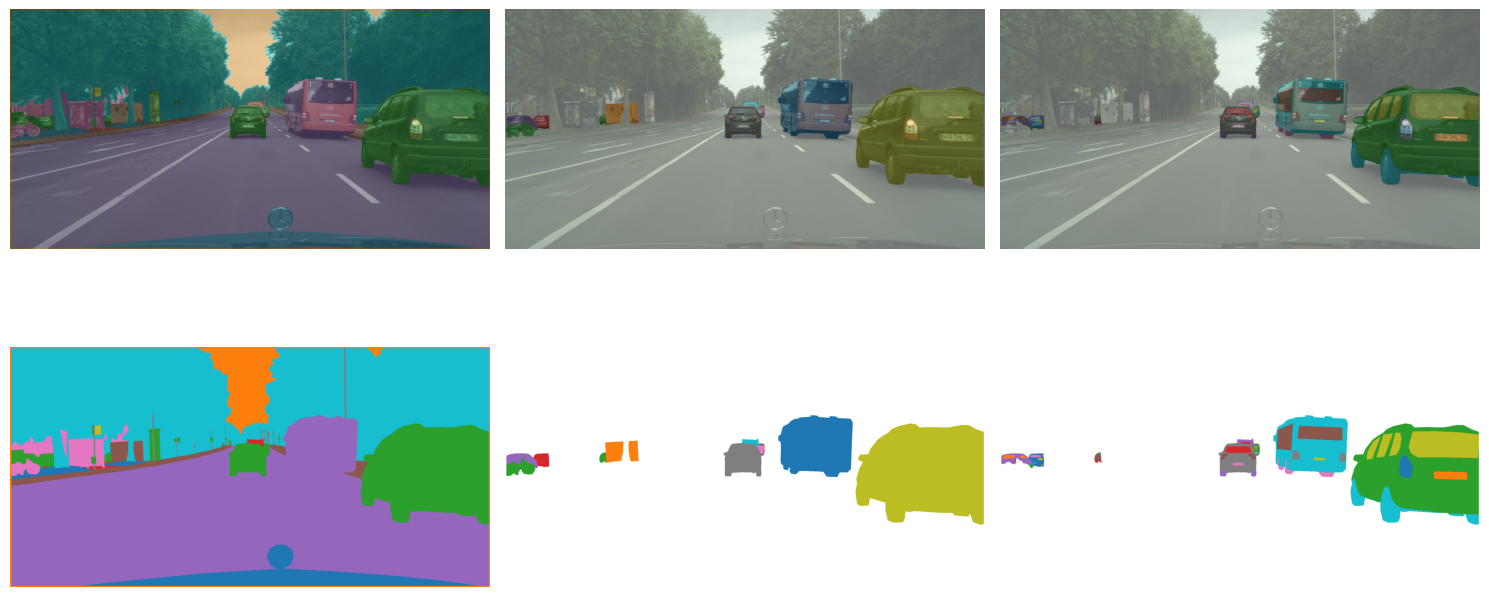

In [4]:
from PIL import Image
cityscapes_ppart_root = Path('/data5/Cityscapes/gtFinePanopticParts')
cityscapes_image_root = Path('/data5/Cityscapes/images')
city_annotations = sorted(list(cityscapes_ppart_root.rglob('*.tif')))
city_image_paths = {path.stem: path for path in cityscapes_image_root.rglob('*.png')}
print(f'There are {len(city_annotations)} annotations')
example = np.random.choice(city_annotations)
print('example:', example)
image_path = city_image_paths[example.stem[:-len('_gtFinePanopticParts')]]
assert image_path.exists(), image_path

# noinspection PyTypeChecker
mask = np.array(Image.open(example))
print('mask:', utils.show_shape(mask), np.unique(mask))

image = utils.load_image(image_path)
mask_1, mask_2, mask_3 = ppart_convert_mask(mask)
plt.figure(figsize=(5 * 3, 4 * 2))
plt.subplot(231)
show_masks(image, mask=mask_1)
plt.subplot(234)
show_masks(None, mask=mask_1)
plt.subplot(232)
show_masks(image, mask=mask_2)
plt.subplot(235)
show_masks(None, mask=mask_2)
plt.subplot(233)
show_masks(image, mask=mask_3)
plt.subplot(236)
show_masks(None, mask=mask_3)
plt.tight_layout()

In [5]:
# load SAM
assert torch.cuda.is_available()
model = build_sam(Path('./weights/sam_vit_h_4b8939.pth').expanduser())
# model = semantic_sam_l(Path("./weights/swinl_only_sam_many2many.pth").expanduser())
# model = semantic_sam_t( Path("./weights/swint_only_sam_many2many.pth").expanduser())
model = model.eval().to(device)
tree_seg = TreePredictor(model, box_nms_thresh=0.7, pred_iou_thresh=0.7)

In [6]:
H, W, _ = image.shape 
scale = min(1024/H, 1024/W)
image = cv2.resize(image, (int(W*scale), int(H*scale)), interpolation=cv2.INTER_AREA)
print(image.shape)

(512, 1024, 3)


numpy((66, 512, 1024), bool), numpy((66,), float32)


4

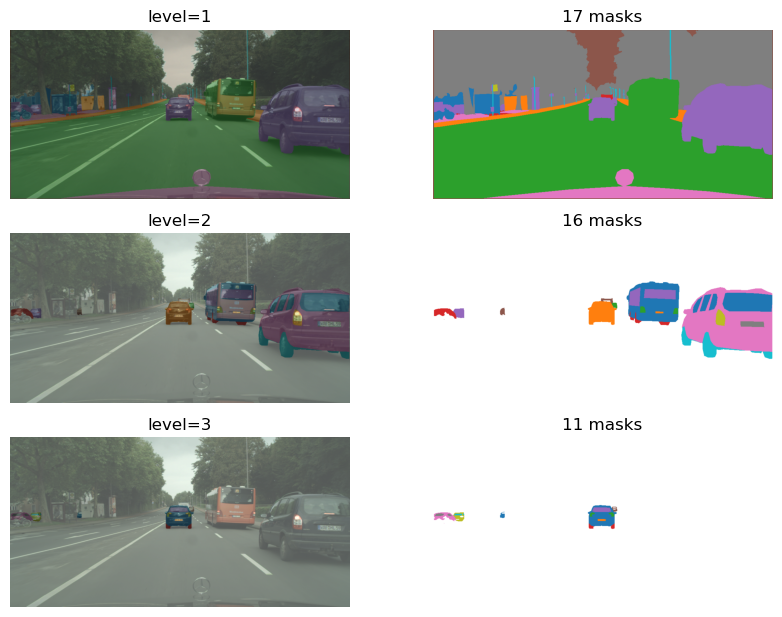

In [7]:
import numpy as np
masks = []
scores = []
for mask_ in [mask_1, mask_2, mask_3]:
    mask_ = cv2.resize(mask_,( image.shape[1], image.shape[0]),  interpolation=cv2.INTER_NEAREST)
    for i in np.unique(mask_):
        if i == 0: 
            continue
        masks.append(mask_ == i)
        scores.append(1)

masks = np.stack(masks)
scores = np.array(scores).astype(np.float32)
print(utils.show_shape(masks, scores))
tree2d = Tree2D(torch.from_numpy(masks).to(device), torch.from_numpy(scores).to(device), device=device)
tree2d.update_tree()
tree2d.remove_not_in_tree()
show_all_levels(image, tree2d)

5

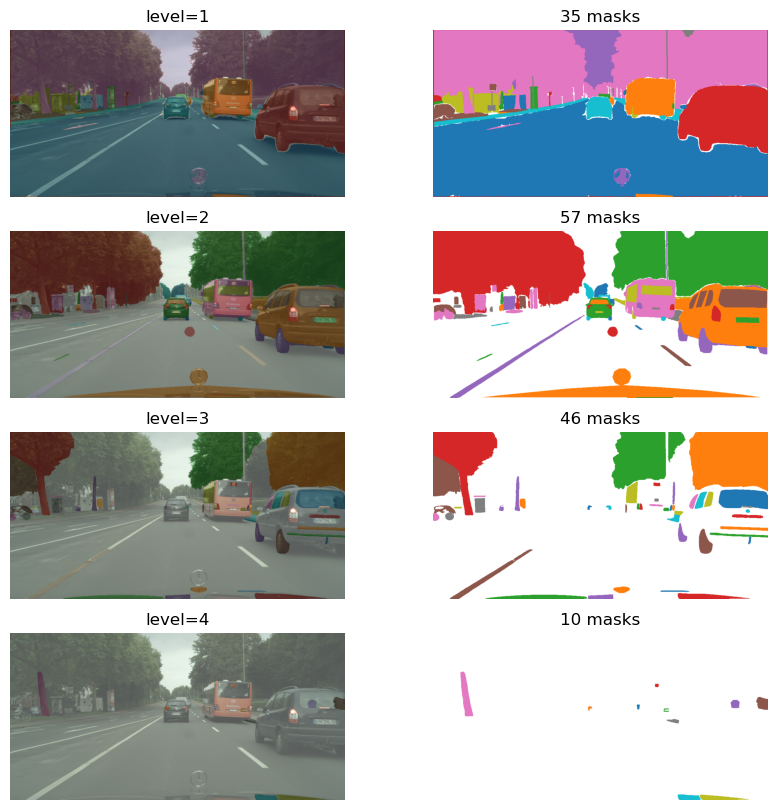

In [10]:
tree2d= tree_seg.tree_generate(image, device=device, tree2d=tree2d)
show_all_levels(image, tree2d)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


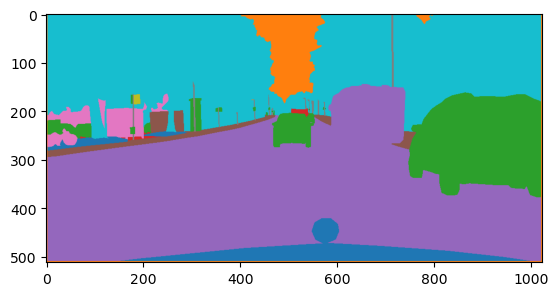

[ 0 13 14 15 16 17 18 19 20 21 22 23]


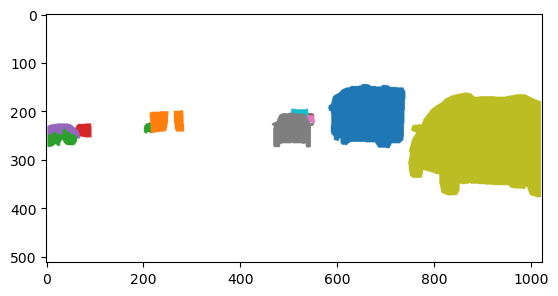

[ 0 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50]


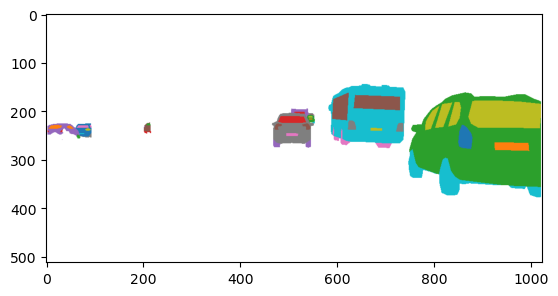

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


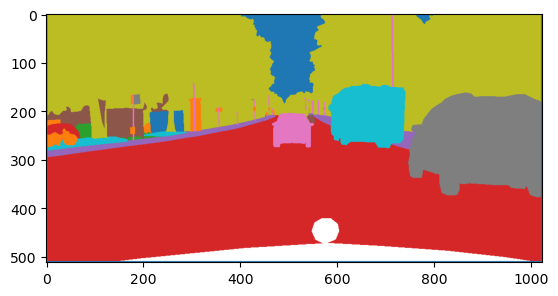

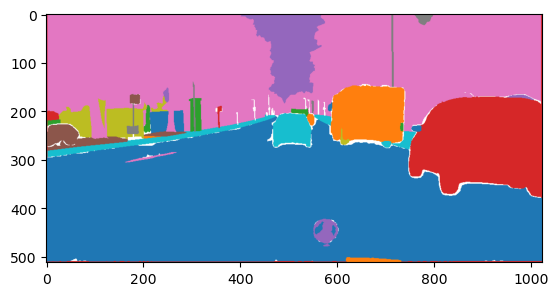

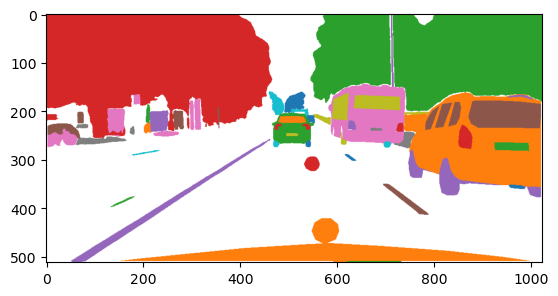

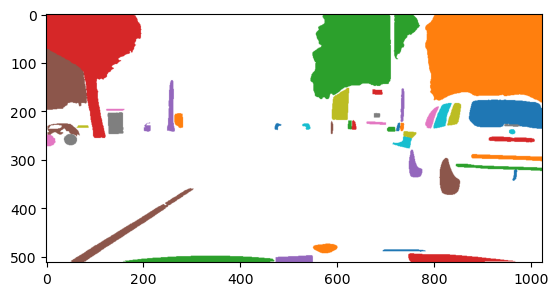

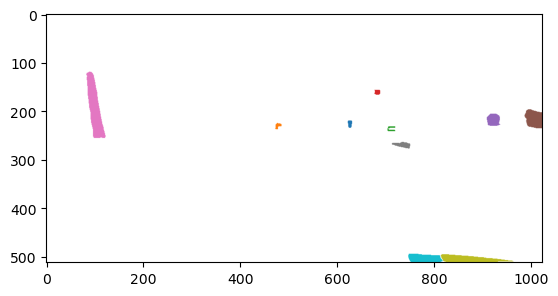

In [31]:
from tree_segmentation.util import color_mask, get_colored_masks
mask_4 = np.where(mask_2>0, mask_2 + np.max(mask_1)+1, mask_1)
x = np.unique(mask_4)
remap = np.zeros(x.max()+1, dtype=int)
remap[x] = np.arange(len(x))
mask_4 = remap[mask_4]

for i, mask_ in enumerate( [mask_1, mask_2, mask_3, mask_4]):
    mask_ = cv2.resize(mask_,( image.shape[1], image.shape[0]),  interpolation=cv2.INTER_NEAREST)
    print(np.unique(mask_))
    img = color_mask(mask_)
    plt.imshow(img)
    plt.show()
    utils.save_image(f'./results/indroduce_o{i}.png', img)
utils.save_image("./results/indroduce_image.png", image)
tree2d.node_rearrange()
G = nx.DiGraph()
node_colors = {}
for i, levels in enumerate(tree2d.get_levels()):
    if i == 0:
        continue
    img = get_colored_masks(tree2d.masks[levels-1])
    plt.imshow(img)
    plt.show()
    utils.save_image(f'./results/indroduce_my_{i}.png', img)
    for j in levels:
        pos = torch.nonzero(tree2d.masks[j-1])
        if len(pos)>0:
            node_colors[j.item()] = img[pos[0, 0], pos[0, 1]]
            G.add_edge(tree2d.parent[j].item(), j.item())


(-390.9, 4424.9, -12.239999999999998, 336.23999999999995)

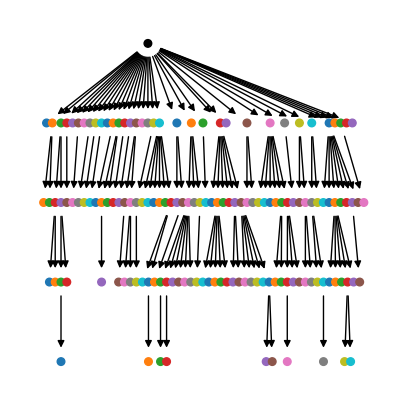

In [33]:
plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
pos = nx.nx_agraph.graphviz_layout(G, prog='dot', root='0')
# nx.draw_networkx_edges(Gg, pos, ax=ax)
nx.draw_networkx(G, pos, ax=ax, with_labels=False, 
    node_color=[node_colors[n] if n in node_colors else (0., 0., 0.) for n in G.nodes],
    node_size=30, min_source_margin=10, min_target_margin=10)
# ax.set_title('ground truth', x=0, y=0.5, rotation=90, pad=0, va='center')
ax.axis('off')

In [3]:
data_root = Path('~/data/SA_1B_110').expanduser()
images_paths = list(data_root.glob('*.jpg'))
print(f"There are {len(images_paths)} images")
print(len(list(data_root.glob('*.json'))))

There are 11186 images
11186


In [4]:
def read_annotations(json_path: Path):
    masks = []
    scores = []
    with open(json_path, 'r') as f:
        data = json.load(f)
    annotations = data['annotations']
    for ann in annotations:
        scores.append(ann['predicted_iou'])
        masks.append(mask_util.decode(ann['segmentation']))
    scores = np.stack(scores)
    masks = np.stack(masks)
    # return masks, scores
    tree2d = Tree2D(MaskData(masks=torch.from_numpy(masks), iou_preds=torch.from_numpy(scores)))
    tree2d.update_tree()
    return tree2d


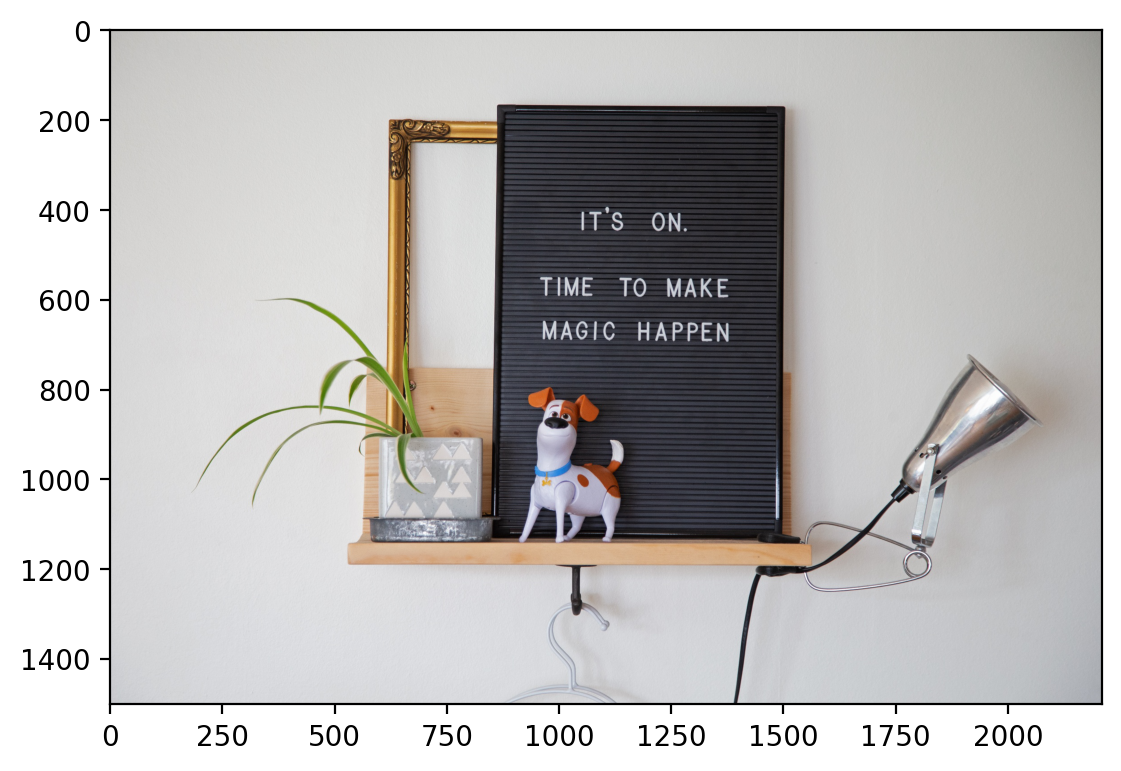

In [5]:
image_path = data_root.joinpath('sa_1231086.jpg')
image = utils.load_image(image_path)
plt.figure(dpi=200)
plt.imshow(image)

36


4

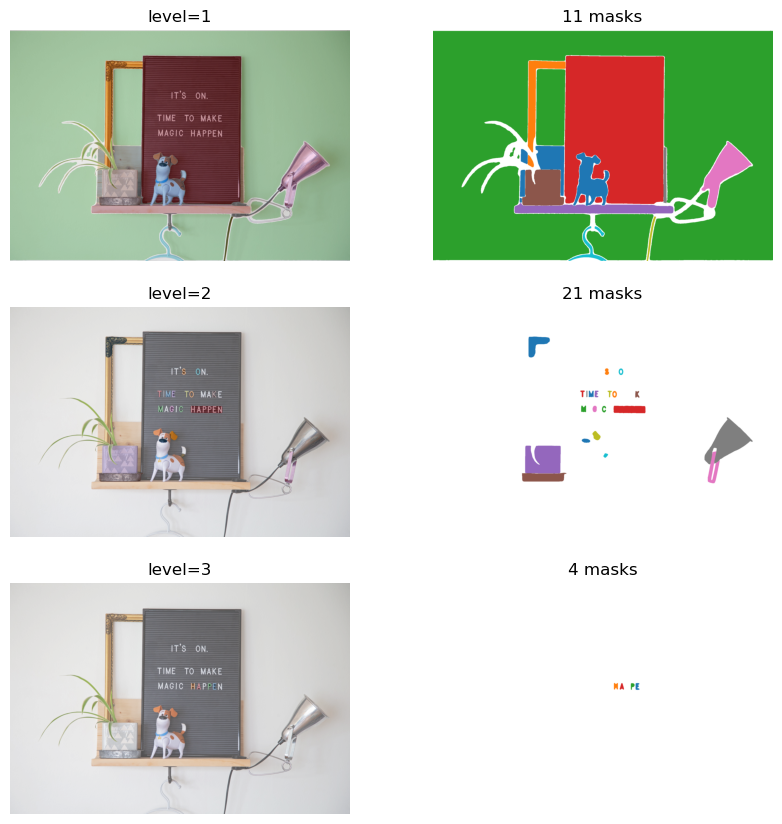

In [6]:
tree2d = read_annotations(image_path.with_suffix('.json'))
print(tree2d.cnt)
show_all_levels(image, tree2d)

In [47]:
save_dir = Path('./results/show_pics')
save_dir.mkdir(exist_ok=True)

for level, nodes in enumerate(tree2d.get_levels()):
    if level == 0:
        utils.save_image(save_dir.joinpath(f"0.png"), image)
        continue
    for x in nodes:
        x = x.item()
        mask = tree2d.masks[x-1]
        utils.save_image(save_dir.joinpath(f"{x}_{tree2d.parent[x].item()}.png"), mask.cpu().numpy()*255)
print(os.curdir)

.


1500 2210


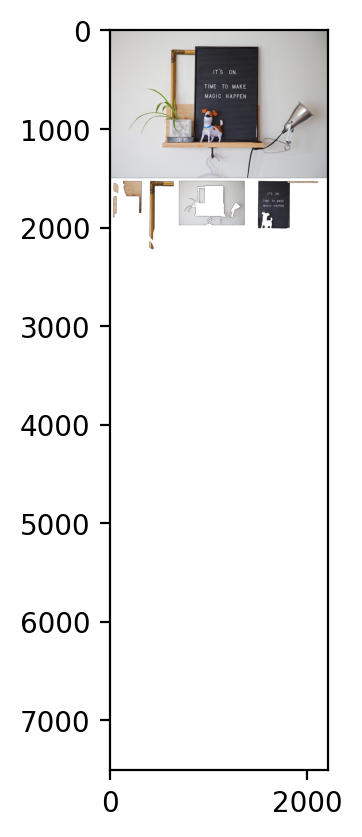

In [40]:
save_dir = Path('./results/show_pics')
save_dir.mkdir(exist_ok=True)

tree2d.node_rearrange()
H, W, C = image.shape 
final = np.zeros((H*5, W, 4), dtype=np.uint8)
final[:H,: , :C] = image
final[:H, :, -1] = 255
print(H, W)

def add_to_final(i, pos, scale=1.):
    mask = tree2d.masks[i].cpu().numpy().astype(np.uint8)*255
    masked_image = np.concatenate([image, mask[:, :, None]], axis=-1)
    row = np.any(mask, axis=0)
    col = np.any(mask, axis=1)
    # print(row.shape, col.shape)
    row = np.nonzero(row)[0]
    col = np.nonzero(col)[0]
    # print(row, col)
    top, down = row[0], row[-1]
    left, right = col[0], col[-1]
    # print(left, right, top, down)
    masked_image = masked_image[left:right+1, top:down+1]
    h, w, _ = masked_image.shape
    if scale != 1.:
        masked_image = cv2.resize(masked_image, (int(w*scale), int(h*scale)))
        h, w, _ = masked_image.shape
    final[pos[1]:pos[1]+h, pos[0]:pos[0]+w, :] = \
        np.where(masked_image[:, :, -1:]>0, masked_image, final[pos[1]:pos[1]+h, pos[0]:pos[0]+w, :])

for level, nodes in enumerate(tree2d.get_levels()):
    if level == 0:
        continue
    if level == 1:
        add_to_final(0, (30, H+30))
        add_to_final(1, (400, H+30))
        add_to_final(2, (700, H+30), 0.3)
        add_to_final(3, (1500, H+30), 0.5)
        add_to_final(4, (1800, H+30), 0.3)

    
plt.figure(dpi=200)
plt.imshow(final)

In [42]:
print(' & '.join(str(v) for v in utils.eval_str("{SQ: 0.6104, RQ: 0.8370, PQ: 0.5081, TS: 0.9971, TQ: 0.5060, mSQ: 0.9195, mRQ: 0.4078, mPQ: 0.3736, mTS: 0.9983, mTQ: 0.3729, mIoU: 0.6078}").values()))

0.6104 & 0.837 & 0.5081 & 0.9971 & 0.506 & 0.9195 & 0.4078 & 0.3736 & 0.9983 & 0.3729 & 0.6078


In [11]:
# load SAM
assert torch.cuda.is_available()
# model = build_sam(Path('./weights/sam_vit_h_4b8939.pth').expanduser())
model = semantic_sam_l(Path("./weights/swinl_only_sam_many2many.pth").expanduser())
# model = semantic_sam_t( Path("./weights/swint_only_sam_many2many.pth").expanduser())
model = model.eval().to(device)
tree_seg = TreePredictor(model, box_nms_thresh=0.7, pred_iou_thresh=0.7)

In [8]:
H, W, _ = image.shape 
scale = min(1024/H, 1024/W)
image = cv2.resize(image, (int(W*scale), int(H*scale)), interpolation=cv2.INTER_AREA)
print(image.shape)

(695, 1024, 3)


In [12]:
prediction = tree_seg.tree_generate(image, verbose=1)

[Tree] reset
[Tree2D] remove_not_in_tree
[Tree] rerange nodes
[Tree] Resize tree from 47 to 43
[Tree2D] complete init segmentation
[Tree] Resize tree from 43 to 44
[Tree] Resize tree from 44 to 45
[Tree] Resize tree from 45 to 46
[Tree2D] Try to insert 25 masks, 0 are ignored
[Tree2D] remove_not_in_tree
[Tree] rerange nodes
[Tree] Resize tree from 46 to 46
[Tree2D] complete step 0 update segmentation
[Tree] Resize tree from 46 to 47
[Tree] Resize tree from 47 to 48
[Tree2D] Try to insert 22 masks, 0 are ignored
[Tree2D] remove_not_in_tree
[Tree] rerange nodes
[Tree] Resize tree from 48 to 48
[Tree2D] complete step 1 update segmentation
[Tree] Resize tree from 48 to 49
[Tree] Resize tree from 49 to 50
[Tree2D] Try to insert 21 masks, 0 are ignored
[Tree2D] remove_not_in_tree
[Tree] rerange nodes
[Tree] Resize tree from 50 to 50
[Tree2D] complete step 2 update segmentation
[Tree] Resize tree from 50 to 51
[Tree] Resize tree from 51 to 52
[Tree] Resize tree from 52 to 53
[Tree] Resize tre

[Tree2D] uncompress masks


5

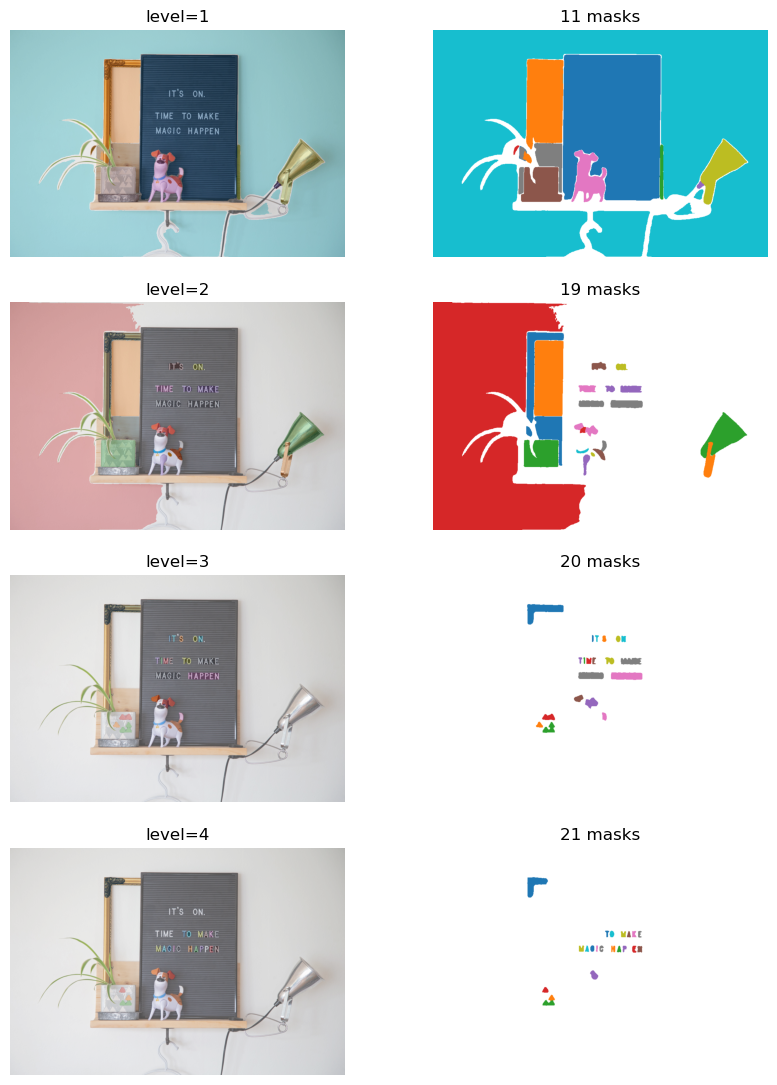

In [13]:
show_all_levels(image, prediction)

In [9]:
def get_cropped(image:Tensor, mask:Tensor):
    # print(utils.show_shape(image, mask))
    mask = mask.cpu().numpy() if isinstance(mask, Tensor) else mask
    if mask.dtype != np.uint8:
        mask = (mask * 255).astype(np.uint8)    
    image = image.cpu().numpy() if isinstance(image, Tensor) else image
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)    
    masked_image = np.concatenate([image, mask], axis=-1)
    row = np.any(mask, axis=0)
    col = np.any(mask, axis=1)
    # print(row.shape, col.shape)
    row = np.nonzero(row)[0]
    col = np.nonzero(col)[0]
    # print(row, col)
    top, down = row[0], row[-1]
    left, right = col[0], col[-1]
    # print(left, right, top, down)
    masked_image = masked_image[left:right+1, top:down+1]
    return masked_image

[0, 36, 25, 24, 23, 22, 21, 19, 16, 13, 7, 5, 2, 35, 33, 32, 31, 30, 28, 27, 26, 1, 9, 10, 12, 20, 6, 8, 15, 17, 34, 14, 3, 29, 4, 11, 18]
[(0, 36), (0, 25), (0, 24), (0, 23), (0, 22), (0, 21), (0, 19), (0, 16), (0, 13), (0, 7), (0, 5), (25, 2), (23, 35), (23, 33), (23, 32), (23, 31), (23, 30), (23, 28), (23, 27), (23, 26), (23, 1), (23, 9), (23, 10), (23, 12), (23, 20), (21, 6), (21, 8), (19, 15), (19, 17), (5, 34), (5, 14), (5, 3), (20, 29), (20, 4), (20, 11), (20, 18)]
[-0.8805 -0.8807]
[0.9525 1.    ]


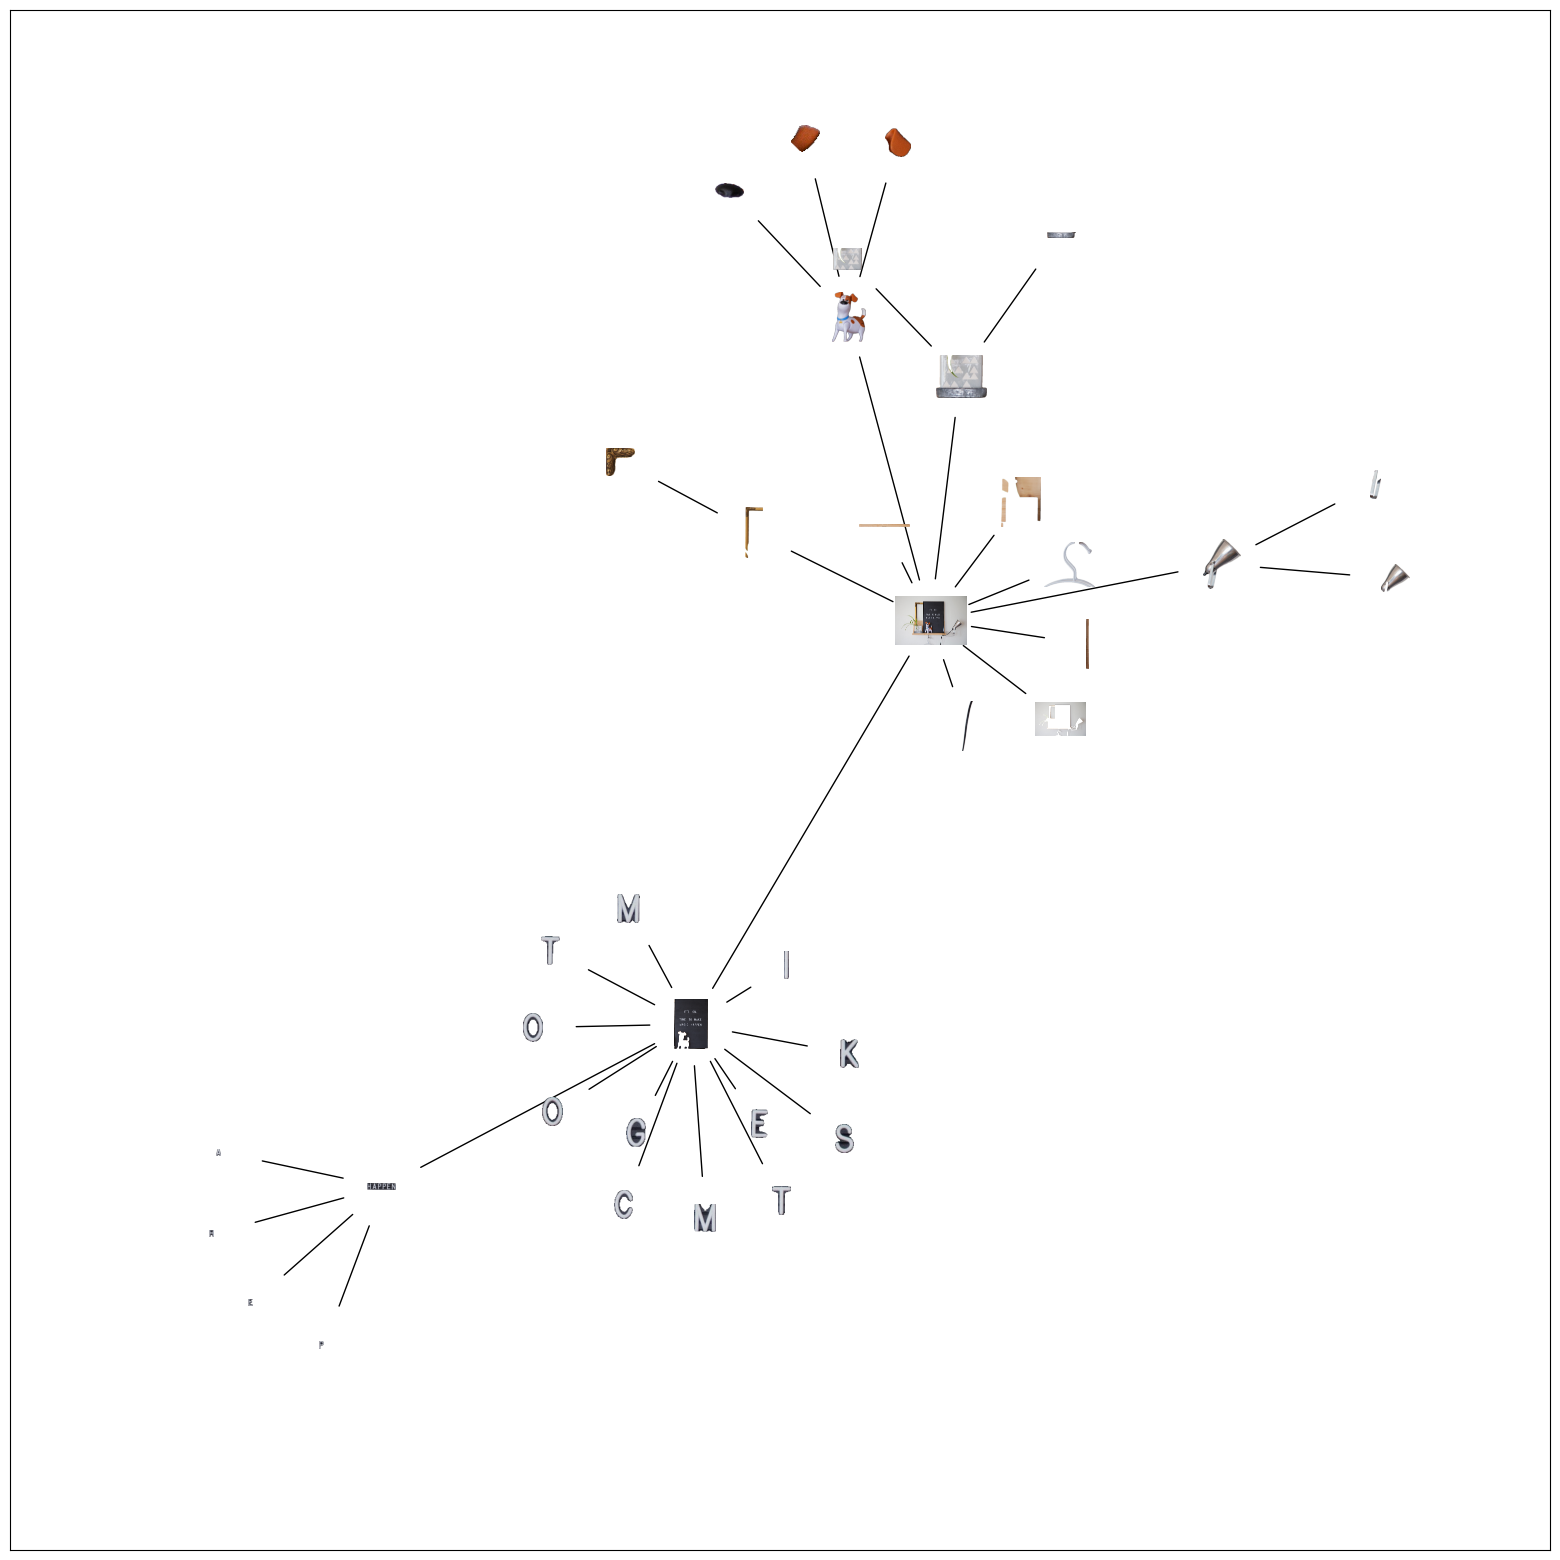

In [41]:
G = nx.Graph()

for level_no, nodes in enumerate(tree2d.get_levels()):
    for x in nodes:
        x = x.item()
        G.add_node(x, level=level_no)
        if x != 0:
            G.add_edge(x, tree2d.parent[x].item())

print(G.nodes())
print(G.edges())
# pos = nx.circular_layout(G)
# pos = nx.multipartite_layout(G)
pos = nx.spring_layout(G)
# pos = nx.nx_agraph.graphviz_layout(G, prog="twopi", root=None, args="")
fig = plt.figure(figsize=(20, 20))
ax = plt.subplot(111)
# ax = fig.add_axes([0, 0, 1, 1])
ax.set_aspect('equal')
# nx.draw_networkx_edges(G, pos, ax=ax)
print(np.min(np.stack(list(pos.values())), axis=0))
print(np.max(np.stack(list(pos.values())), axis=0))
nx.draw_networkx_edges(
    G,
    pos=pos,
    ax=ax,
    arrows=True,
    arrowstyle="-",
    min_source_margin=30,
    min_target_margin=30,
)

plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
tr_figure = ax.transData.transform
# Transform from display to figure coordinates
tr_axes = fig.transFigure.inverted().transform

# Select the size of the image (relative to the X axis)
icon_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.015
icon_center = icon_size / 2.0

# Add the respective image to each node
for n in G.nodes:
    xf, yf = tr_figure(pos[n])
    xa, ya = tr_axes((xf, yf))
    # get overlapped axes and plot icon
    level = G.nodes[n]['level']
    img = image if n == 0 else get_cropped(image, tree2d.masks[n - 1, :, :, None].bool().cpu())
    size = icon_size * (1 - 0.3 * level)
    a = plt.axes([xa - size * 0.5, ya - size * 0.5, size, size])
    a.set_aspect('equal')
    a.imshow(img)
    a.axis("off")
plt.show()